In [ ]:
# Import DS Python Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import ML stuff
import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Training Tracking
from tqdm import trange
from time import time

In [ ]:
from google.colab import drive
drive.mount('/drive')
%cd "/drive/MyDrive/TAMU Fall 2024/STAT647"

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).
/drive/MyDrive/TAMU Fall 2024/STAT647


# Getting the Data

In [ ]:
no2_data = pd.read_csv("NO2_CONUS_full_data.csv",
                       dtype = {"State.Code" : "category", "County.Code" : "category", "GEOID" : "category"})
no2_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475 entries, 0 to 474
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   State.Code               475 non-null    category
 1   County.Code              475 non-null    category
 2   Latitude                 475 non-null    float64 
 3   Longitude                475 non-null    float64 
 4   Datum                    475 non-null    object  
 5   Sample.Duration          475 non-null    object  
 6   Metric.Used              475 non-null    object  
 7   Units.of.Measure         475 non-null    object  
 8   Observation.Count        475 non-null    int64   
 9   Observation.Percent      475 non-null    int64   
 10  Arithmetic.Mean          475 non-null    float64 
 11  Arithmetic.Standard.Dev  475 non-null    float64 
 12  X50th.Percentile         475 non-null    float64 
 13  GEOID                    475 non-null    category
 14  total_popu

In [ ]:
no2_data["perc_no_vehicle"] = no2_data["total_no_vehicle"] / no2_data["total_population"]
no2_data["perc_carpool_vehicle"] = no2_data["total_carpool_vehicle"] / no2_data["total_population"]
no2_data["perc_private_vehicle"] = no2_data["total_private_vehicle"] / no2_data["total_population"]
no2_data["perc_public_transit"] = no2_data["total_public_transit"] / no2_data["total_population"]
no2_data = no2_data.drop(["total_no_vehicle", "total_carpool_vehicle", "total_private_vehicle", "total_public_transit"], axis = 1)

In [ ]:
no2_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475 entries, 0 to 474
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   State.Code               475 non-null    category
 1   County.Code              475 non-null    category
 2   Latitude                 475 non-null    float64 
 3   Longitude                475 non-null    float64 
 4   Datum                    475 non-null    object  
 5   Sample.Duration          475 non-null    object  
 6   Metric.Used              475 non-null    object  
 7   Units.of.Measure         475 non-null    object  
 8   Observation.Count        475 non-null    int64   
 9   Observation.Percent      475 non-null    int64   
 10  Arithmetic.Mean          475 non-null    float64 
 11  Arithmetic.Standard.Dev  475 non-null    float64 
 12  X50th.Percentile         475 non-null    float64 
 13  GEOID                    475 non-null    category
 14  total_popu

In [ ]:
no2_data.isna().sum()

,0
State.Code,0
County.Code,0
Latitude,0
Longitude,0
Datum,0
Sample.Duration,0
Metric.Used,0
Units.of.Measure,0
Observation.Count,0
Observation.Percent,0


# Training the Model

In [ ]:
X = no2_data[["State.Code", "GEOID", "Latitude", "Longitude", "total_population",
              "ppt", "tmax", "tmean", "tmin", "perc_no_vehicle", "perc_carpool_vehicle",
              "perc_private_vehicle", "perc_public_transit"]]
y = no2_data["X50th.Percentile"].values

In [ ]:
# Train-valid-test split 80-10-10%
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_holdout, y_holdout, test_size = 0.5, random_state = 42)

In [ ]:
X_train.shape, X_val.shape, X_test.shape

((380, 13), (47, 13), (48, 13))

In [ ]:
# Start model timer
start = time()

# Init model
opt_model = xgb.XGBRegressor(objective = "reg:squarederror",
                             learning_rate = 0.01,
                             colsample_bytree = 0.8,
                             eval_metric = 'rmse',
                             early_stopping_rounds = 10,
                             # missing = np.nan,
                             enable_categorical = True,
                             max_depth = 6,
                             verbosity = 0)

opt_dict = {'n_estimators': [200, 250, 300, 350, 400, 450, 500],
            'max_depth' : [3, 4, 5, 6]}

model = GridSearchCV(opt_model, opt_dict,
                     scoring = 'neg_mean_squared_error', verbose = 1)

model.fit(X_train,y_train,
          eval_set = [(X_train, y_train), (X_val, y_val)],
          verbose = False)

end = time()
print("Took", round(((end- start) / 60), 4), "minutes to search for the best model.")

Fitting 5 folds for each of 28 candidates, totalling 140 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Took 1.8704 minutes to search for the best model.


In [ ]:
model.best_params_

{'max_depth': 4, 'n_estimators': 200}

In [ ]:
import pickle

# Saving data by pickling data into pkl files to avoid running code for data again
with open('best_model_w_covariates.pkl', 'wb') as file:
    pickle.dump(model, file)

In [ ]:
# Fit the best XGBoost model
XGBReg = xgb.XGBRegressor(objective = "reg:squarederror",
                          learning_rate = 0.01,
                          colsample_bytree = 0.8,
                          eval_metric = 'rmse',
                          early_stopping_rounds = 10,
                          max_depth = 4,
                          n_estimators = 200,
                          enable_categorical = True,
                          missing = np.nan,
                          verbosity = 0).fit(X_train, y_train,
                                             eval_set = [(X_train, y_train),
                                              (X_val, y_val)],
                                             verbose = False)

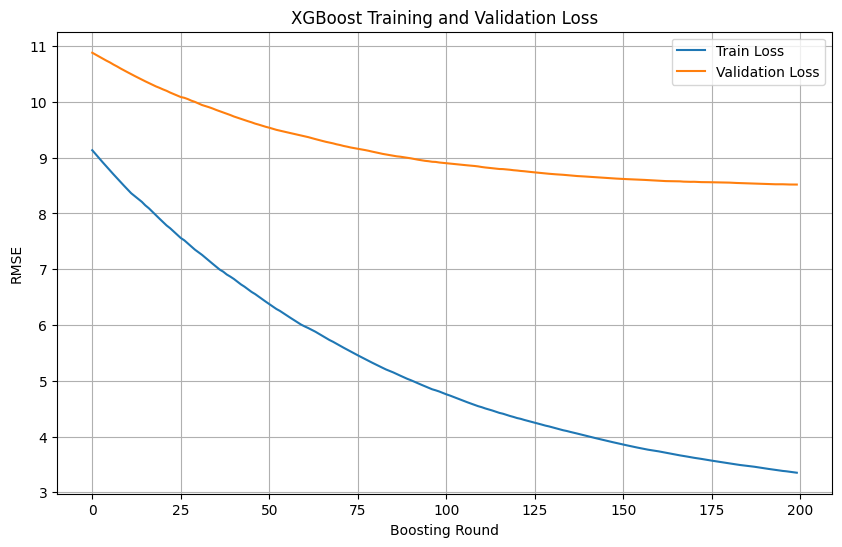

In [ ]:
# Get evaluation results
results = XGBReg.evals_result()

# Extract train and validation loss
train_loss = results['validation_0']['rmse']
val_loss = results['validation_1']['rmse']

# Plot losses
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label = 'Train Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.xlabel('Boosting Round')
plt.ylabel('RMSE')
plt.title('XGBoost Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Test Metrics and Evaluation

In [ ]:
def smape(y_hat, y):
  return round(np.mean(
      np.abs(y_hat - y) / ((np.abs(y_hat) + np.abs(y))/2)
      )*100, 2)

In [ ]:
y_pred_test = XGBReg.predict(X_test)
y_pred_valid = XGBReg.predict(X_val)
y_pred_train = XGBReg.predict(X_train)

In [ ]:
print("RMSE Train:", metrics.root_mean_squared_error(y_train, y_pred_train))
print("RMSE Valid:", metrics.root_mean_squared_error(y_val, y_pred_valid))
print("RMSE Test:", metrics.root_mean_squared_error(y_test, y_pred_test), "\n")
print("SMAPE Train:", smape(y_train, y_pred_train))
print("SMAPE Valid:", smape(y_val, y_pred_valid))
print("SMAPE Test:", smape(y_test, y_pred_test))

RMSE Train: 3.360026055478355
RMSE Valid: 8.517376887251332
RMSE Test: 8.38364933550421 

SMAPE Train: 23.64
SMAPE Valid: 53.17
SMAPE Test: 56.1


### Feature Importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

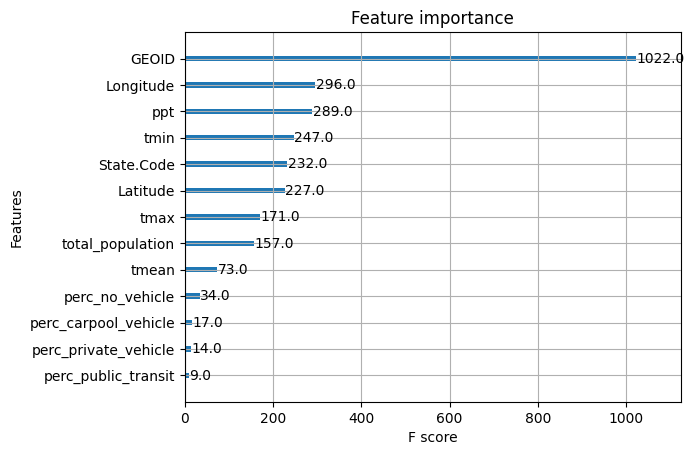

In [ ]:
XGBReg.get_booster().feature_names = X.columns.to_list()
xgb.plot_importance(XGBReg, max_num_features = 20)